## Introdução à Regressão Logística

A Regressão Logística é um algoritmo de classificação utilizado para prever a probabilidade de uma instância pertencer a uma determinada classe. É mais adequada para problemas de classificação binária (2 classes), mas pode ser estendida para problemas multiclass.

A função principal usada é a **função sigmoide**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Essa função transforma qualquer valor real em um valor entre 0 e 1, que pode ser interpretado como uma probabilidade.

### Função de Custo

A função de custo usada é a *log-loss* (também chamada de entropia cruzada):

$$
J(\theta) = - \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]
$$

onde:
- $m$ é o número de exemplos
- $y^{(i)}$ é o rótulo verdadeiro do exemplo $i$
- $h_\theta(x^{(i)})$ é a predição da regressão logística para o exemplo $x^{(i)}$

A otimização é geralmente feita com **Gradiente Descendente**.



## Desafio Escolhido: Multiclass Classification

Neste projeto, escolhemos abordar o desafio da **classificação multiclasse**, onde o objetivo é classificar instâncias em mais de duas classes.

A Regressão Logística tradicional funciona apenas para problemas de classificação binária. Por isso, nesta primeira fase vamos implementar e testar a versão binária, e na segunda fase vamos propor uma extensão do algoritmo para lidar com múltiplas classes.

Duas abordagens possíveis para lidar com múltiplas classes são:
- **One-vs-Rest (OvR)**: Treinar um modelo binário para cada classe contra todas as outras.
- **Regressão Softmax** (também chamada de Regressão Logística Multinomial): Estende a função sigmoide para múltiplas classes usando a função softmax.


**Algorítmo Logistic Regression** retirado do github

In [1]:
import logging
import autograd.numpy as np
from autograd import grad

np.random.seed(1000)

## Classe `BaseEstimator`

A classe `BaseEstimator` serve como classe base para algoritmos de aprendizagem supervisionada, fornecendo funcionalidades comuns como tratamento de entrada e validações iniciais.

### Atributos:

- `y_required`: Indica se o vetor de rótulos (`y`) é obrigatório. Padrão: `True`.
- `fit_required`: Indica se é necessário treinar (`fit`) antes de fazer previsões. Padrão: `True`.

### Métodos:

#### `_setup_input(self, X, y=None)`
Prepara os dados de entrada para o modelo:
- Converte `X` (e `y`, se necessário) em `np.array`.
- Verifica se `X` não está vazio.
- Define o número de amostras e de atributos a partir da forma de `X`.
- Armazena os dados em `self.X` e `self.y`.

#### `fit(self, X, y=None)`
Treina o modelo — aqui apenas chama `_setup_input` para preparar os dados. 

#### `predict(self, X=None)`
Faz previsões sobre `X`. Verifica se o modelo foi treinado (dependendo do `fit_required`) e então chama o método `_predict`.

#### `_predict(self, X=None)`
Este é um **método abstrato** que deve ser implementado pelas classes que herdarem de `BaseEstimator`. Ele contém a lógica específica de previsão de cada modelo.

---

### Observações:
- Essa classe é útil para evitar repetição de código ao implementar diferentes algoritmos.
- Segue um padrão semelhante ao usado no `scikit-learn`, com métodos `fit` e `predict`.


In [2]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be non-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()


In [3]:
EPS = 1e-15

def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

## Classes `BasicRegression` e `LogisticRegression`

Estas classes implementam uma regressão logística do zero, estendendo a classe `BaseEstimator`. A lógica de otimização é feita com **Gradiente Descendente**, e o código permite adicionar regularização (`l1` ou `l2`).

### Classe `BasicRegression`

A `BasicRegression` é uma classe abstrata para modelos de regressão com gradiente descendente e regularização.

#### Construtor (`__init__`)
Define os principais hiperparâmetros do modelo:
- `lr`: taxa de aprendizagem
- `penalty`: tipo de regularização ("None", "l1" ou "l2")
- `C`: intensidade da regularização
- `tolerance`: critério de paragem baseado na convergência
- `max_iters`: número máximo de iterações
- Também inicializa arrays para os pesos (`theta`) e para o histórico de erro (`errors`).

#### Métodos principais:

- `fit(X, y)`: 
  - Inicializa parâmetros,
  - Adiciona o termo de bias (interceção),
  - Chama o método `_train()`.

- `_add_intercept(X)`: Adiciona uma coluna de 1s ao início de `X` para o termo de bias.

- `_train()`: Atualiza os pesos usando gradiente descendente.

- `_gradient_descent()`: Implementa o ciclo de otimização:
  - Calcula gradiente do erro em relação aos pesos,
  - Atualiza os pesos com base nesse gradiente,
  - Verifica convergência.

- `_add_penalty(loss, w)`: Adiciona o termo de regularização `l1` ou `l2` ao erro, se aplicável.

- `_predict(X)`: Realiza previsão com os pesos treinados (linear).

---

### Classe `LogisticRegression`

Extensão da `BasicRegression` que implementa regressão logística binária.

#### Métodos:

- `init_cost()`: Define a função de custo como entropia cruzada binária.

- `_loss(w)`: Calcula o erro da regressão logística, com regularização se aplicável.

- `sigmoid(x)`: Função de ativação sigmoide, usada para transformar valores contínuos em probabilidades.

- `_predict(X)`: Realiza a previsão aplicando a função sigmoide à combinação linear dos atributos.

---

### Observações:
- A classe é modular e permite fácil extensão para outros tipos de regressão.
- A regularização é aplicada apenas aos coeficientes, excluindo o termo de bias (`w[1:]`).
- O uso de `grad` sugere que a biblioteca `autograd` está a ser usada para calcular derivadas automaticamente.




In [4]:
class BasicRegression(BaseEstimator):
    def __init__(self, lr=0.001, penalty="None", C=0.01, tolerance=0.0001, max_iters=1000):
        self.C = C
        self.penalty = penalty
        self.tolerance = tolerance
        self.lr = lr
        self.max_iters = max_iters
        self.errors = []
        self.theta = []
        self.n_samples, self.n_features = None, None
        self.cost_func = None

    def _loss(self, w):
        raise NotImplementedError()

    def init_cost(self):
        raise NotImplementedError()

    def _add_penalty(self, loss, w):
        if self.penalty == "l1":
            loss += self.C * np.abs(w[1:]).sum()
        elif self.penalty == "l2":
            loss += (0.5 * self.C) * (w[1:] ** 2).sum()
        return loss

    def _cost(self, X, y, theta):
        prediction = X.dot(theta)
        error = self.cost_func(y, prediction)
        return error

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.init_cost()
        self.n_samples, self.n_features = X.shape
        self.theta = np.random.normal(size=(self.n_features + 1), scale=0.5)
        self.X = self._add_intercept(self.X)
        self._train()

    @staticmethod
    def _add_intercept(X):
        b = np.ones([X.shape[0], 1])
        return np.concatenate([b, X], axis=1)

    def _train(self):
        self.theta, self.errors = self._gradient_descent()
        logging.info(" Theta: %s" % self.theta.flatten())

    def _predict(self, X=None):
        X = self._add_intercept(X)
        return X.dot(self.theta)

    def _gradient_descent(self):
        theta = self.theta
        errors = [self._cost(self.X, self.y, theta)]
        cost_d = grad(self._loss)
        for i in range(1, self.max_iters + 1):
            delta = cost_d(theta)
            theta -= self.lr * delta
            errors.append(self._cost(self.X, self.y, theta))
            error_diff = np.linalg.norm(errors[i - 1] - errors[i])
            if error_diff < self.tolerance:
                logging.info("Convergence has reached.")
                break
        return theta, errors

class LogisticRegression(BasicRegression):
    def init_cost(self):
        self.cost_func = binary_crossentropy

    def _loss(self, w):
        loss = self.cost_func(self.y, self.sigmoid(np.dot(self.X, w)))
        return self._add_penalty(loss, w)

    @staticmethod
    def sigmoid(x):
        return 0.5 * (np.tanh(0.5 * x) + 1)

    def _predict(self, X=None):
        X = self._add_intercept(X)
        return self.sigmoid(X.dot(self.theta))

**Teste para o dataset: "dataset_61_iris.csv"**

In [5]:
import pandas as pd
import numpy as onp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [6]:
# Carregar o dataset completo com as 3 classes
iris_df = pd.read_csv("multiclass_classification/dataset_61_iris.csv")

# Features
X = iris_df.iloc[:, :-1].values
y = iris_df.iloc[:, -1].values

# Converter classes para valores inteiros: setosa = 0, versicolor = 1, virginica = 2
le = LabelEncoder()
y = le.fit_transform(y)
print("Classes codificadas:", list(le.classes_))

Classes codificadas: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

## Hipótese

Como a Regressão Logística foi projetada para classificação binária, esperamos que o seu desempenho em problemas multiclasse seja limitado se não for modificada.

Sem adaptações, o modelo apenas consegue prever entre duas classes, e qualquer tentativa de aplicar diretamente em problemas com mais de duas classes resultará numa performance inferior.

Na segunda fase, vamos propor uma alteração ao algoritmo — provavelmente via *One-vs-Rest* ou *Softmax* — de forma a torná-lo mais robusto e compatível com classificação multiclasse.


In [8]:
model = LogisticRegression(lr=0.01, max_iters=5000)
model.fit(X_train, y_train)

probs = model._predict(X_test)
y_pred = np.round(probs).astype(int)

In [9]:
print("Valores reais (y_test):", onp.unique(y_test))
print("Valores previstos (y_pred):", onp.unique(y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Valores reais (y_test): [0 1 2]
Valores previstos (y_pred): [1]
Accuracy: 0.3333333333333333
Confusion Matrix:
 [[ 0 15  0]
 [ 0 15  0]
 [ 0 15  0]]


**Outra forma de visualização**

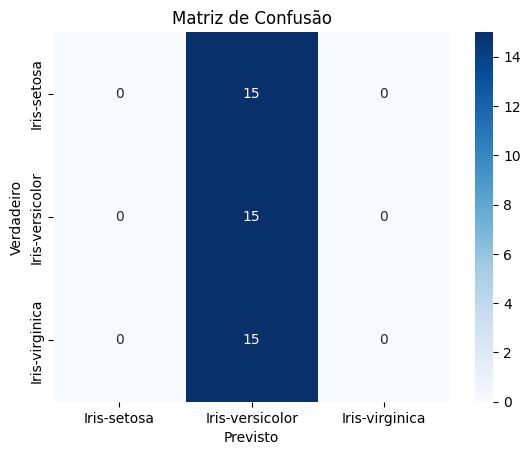

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

**Teste para o dataset: "dataset_54_vehicle.csv"**

In [11]:
# Carregar dataset dos veículos
vehicle_df = pd.read_csv("multiclass_classification/dataset_54_vehicle.csv")

# Separar features e labels
X = vehicle_df.iloc[:, :-1].values  # todas as colunas menos a última
y = vehicle_df.iloc[:, -1].values  # última coluna é a classe

# Codificar as classes como inteiros
le = LabelEncoder()
y = le.fit_transform(y)
print("Classes codificadas:", list(le.classes_))

Classes codificadas: ['bus', 'opel', 'saab', 'van']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [13]:
model = LogisticRegression(lr=0.01, max_iters=5000)
model.fit(X_train, y_train)

# Prever
probs = model._predict(X_test)
y_pred = np.round(probs).astype(int)

In [14]:
print("Valores reais (y_test):", onp.unique(y_test))
print("Valores previstos (y_pred):", onp.unique(y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Valores reais (y_test): [0 1 2 3]
Valores previstos (y_pred): [1]
Accuracy: 0.25196850393700787
Confusion Matrix:
 [[ 0 65  0  0]
 [ 0 64  0  0]
 [ 0 65  0  0]
 [ 0 60  0  0]]


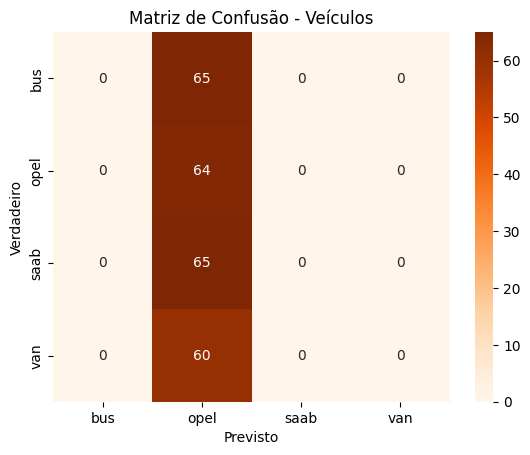

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Veículos")
plt.show()

**Teste para o dataset: "dataset_336_SPECT.csv" da pasta noise/outliers**

**Objetivo:** provar que o algorítmo já funciona relativamente bem para datasets com 2 classes

In [16]:
# Carregar o dataset SPECT
df_spect = pd.read_csv("noise_outliers/dataset_336_SPECT.csv")

# Separar features e labels
X = df_spect.iloc[:, :-1].values
y = df_spect.iloc[:, -1].values

# Codificar as classes (0, 1) como inteiros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

print("Classes codificadas:", list(le.classes_))

Classes codificadas: [np.int64(0), np.int64(1)]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [18]:
model = LogisticRegression(lr=0.01, max_iters=5000)
model.fit(X_train, y_train)

probs = model._predict(X_test)
y_pred = np.round(probs).astype(int)

In [19]:
print("Valores reais (y_test):", np.unique(y_test))
print("Valores previstos (y_pred):", np.unique(y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Valores reais (y_test): [0 1]
Valores previstos (y_pred): [0 1]
Accuracy: 0.8395061728395061
Confusion Matrix:
 [[ 7 10]
 [ 3 61]]


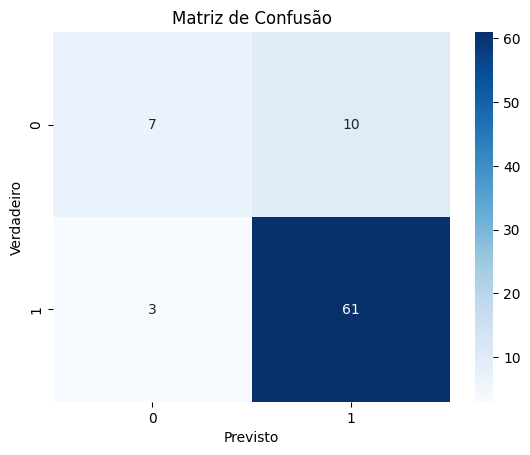

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

**Conclusão**

O algoritmo ainda não está preparado para lidar com datasets com mais de 2 classes.

**Bibliografia**

https://github.com/rushter/MLAlgorithms/blob/master/mla/linear_models.py

https://github.com/rushter/MLAlgorithms/blob/master/mla/base/base.py

https://github.com/rushter/MLAlgorithms/blob/master/mla/metrics/metrics.py

## Parte 2

In [21]:
import numpy as np
import logging
from autograd import grad
from sklearn.preprocessing import LabelEncoder
import autograd.numpy as np
import autograd.numpy as anp   

##  Abordagem 1: Regressão Logística Multinomial (Softmax)

### Objetivo
Resolver problemas de **classificação multiclasse** (mais de duas classes) generalizando a regressão logística binária. 
Nesta abordagem, treinamos um **único modelo** que simultaneamente separa todas as classes, em vez de treinar um modelo por classe (como no método One-vs-Rest).

---

###  Funções de Apoio

#### `softmax(x)`
- Transforma logits (saídas lineares) em **probabilidades** para cada classe.
- Usa uma versão numericamente estável (subtrai o máximo de cada linha antes da exponenciação).

#### `categorical_crossentropy(actual, predicted)`
- Função de custo para **classificação multiclasse**.
- Mede a divergência entre os rótulos verdadeiros (codificados em one-hot) e as probabilidades previstas (softmax).

---

###  Classe `MultinomialLogisticRegression`

A classe herda de `BasicRegression` e implementa a lógica para classificação multiclasse com softmax.

####  Inicialização (`__init__`)
Define os principais **hiperparâmetros**:
- `lr`: taxa de aprendizagem
- `penalty`: tipo de regularização ("None", "l1", "l2")
- `C`: intensidade da regularização
- `tolerance`: critério de paragem baseado em convergência
- `max_iters`: número máximo de iterações
- Também inicializa:
  - `label_encoder`: converte rótulos para inteiros
  - `n_classes`: número de classes distintas

---

###  Treino

#### `fit(X, y)`
1. Pré-processa os dados com `_setup_input`.
2. Codifica os rótulos com `LabelEncoder`.
3. Aplica **one-hot encoding** nos rótulos.
4. Inicializa os pesos `theta` com valores aleatórios.
5. Adiciona um **termo de bias** à matriz `X`.
6. Treina os pesos com descida de gradiente (`_train`).

---

#### `_loss(theta)`
Calcula a função de custo:
- Calcula `logits = X @ theta`
- Aplica `softmax(logits)` para obter probabilidades
- Calcula a perda com `categorical_crossentropy`
- Adiciona regularização (L1 ou L2) se aplicável

---

#### `_train()`
Executa o processo de **descida de gradiente**:
- Usa `autograd.grad` para obter o gradiente da função de custo
- Atualiza os pesos `theta` a cada iteração
- Para quando a perda converge ou atinge o número máximo de iterações

---

###  Predição

#### `predict_proba(X)`
- Devolve as **probabilidades por classe** de cada amostra.

#### `_predict(X)`
- Seleciona a classe com maior probabilidade
- Converte os índices numéricos de volta para rótulos com `inverse_transform`

---

###  Conclusão
Este modelo permite realizar **classificação multiclasse de forma direta**, sem necessidade de treinar múltiplos modelos binários. 
A abordagem com softmax é mais **elegante e eficiente**, especialmente em conjuntos de dados equilibrados com múltiplas classes.


In [22]:
EPS = 1e-15

def softmax(x):
    """Numerically stable softmax implementation"""
    # Subtract max for numerical stability
    x_shifted = x - anp.max(x, axis=1, keepdims=True)
    exp_x = anp.exp(x_shifted)
    return exp_x / anp.sum(exp_x, axis=1, keepdims=True)

def categorical_crossentropy(actual, predicted):
    """Categorical cross-entropy loss for multiclass classification"""
    predicted = anp.clip(predicted, EPS, 1 - EPS)
    return -anp.mean(anp.sum(actual * anp.log(predicted), axis=1))

def binary_crossentropy(actual, predicted):
    predicted = anp.clip(predicted, EPS, 1 - EPS)
    return anp.mean(-anp.sum(actual * anp.log(predicted) + (1 - actual) * anp.log(1 - predicted)))

In [23]:
# APPROACH 1: Multinomial Logistic Regression (Softmax)
class MultinomialLogisticRegression(BasicRegression):
    def __init__(self, lr=0.001, penalty="None", C=0.01, tolerance=0.0001, max_iters=1000):
        super().__init__(lr, penalty, C, tolerance, max_iters)
        self.label_encoder = LabelEncoder()
        self.n_classes = None
        
    def _one_hot_encode(self, y):
        """Convert labels to one-hot encoding"""
        n_samples = len(y)
        one_hot = anp.zeros((n_samples, self.n_classes))
        one_hot[anp.arange(n_samples), y] = 1
        return one_hot
    
    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.y_encoded = self.label_encoder.fit_transform(self.y)
        self.n_classes = len(self.label_encoder.classes_)
        self.y_one_hot = self._one_hot_encode(self.y_encoded)
        
        self.n_samples, self.n_features = X.shape
        self.theta = anp.random.normal(size=(self.n_features + 1, self.n_classes), scale=0.01)
        
        self.X = self._add_intercept(self.X)
        
        self._train()
    
    def _loss(self, theta):
        """Compute the loss for multinomial logistic regression"""
        theta_matrix = theta.reshape(self.n_features + 1, self.n_classes)
        logits = anp.dot(self.X, theta_matrix)
        probabilities = softmax(logits)
        
        loss = categorical_crossentropy(self.y_one_hot, probabilities)
        
        if self.penalty == "l1":
            loss += self.C * anp.sum(anp.abs(theta_matrix[1:]))  
        elif self.penalty == "l2":
            loss += 0.5 * self.C * anp.sum(theta_matrix[1:] ** 2)  
            
        return loss
    
    def _train(self):
        """Train using gradient descent"""
        theta_flat = self.theta.flatten()
        errors = []
        
        grad_loss = grad(self._loss)
        
        for i in range(self.max_iters):
            current_loss = self._loss(theta_flat)
            errors.append(current_loss)
            
            gradients = grad_loss(theta_flat)
            
            theta_flat -= self.lr * gradients
            
            if i > 0 and abs(errors[i-1] - errors[i]) < self.tolerance:
                logging.info(f"Convergence reached at iteration {i}")
                break
        
        self.theta = theta_flat.reshape(self.n_features + 1, self.n_classes)
        self.errors = errors
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X = self._add_intercept(X)
        logits = np.dot(X, self.theta)
        return softmax(logits)
    
    def _predict(self, X):
        """Predict class labels"""
        probabilities = self.predict_proba(X)
        predicted_encoded = anp.argmax(probabilities, axis=1)
        return self.label_encoder.inverse_transform(predicted_encoded)

### Abordagem 2: Regressão Logística One-vs-Rest (OvR)

Esta abordagem permite usar Regressão Logística Binária para problemas de classificação com múltiplas classes. O princípio é simples: treinamos **um classificador binário para cada classe**, onde:

- A classe atual é considerada como **classe positiva (1)**;
- Todas as outras classes são consideradas como **classe negativa (0)**.

#### `BinaryLogisticRegression`
Implementa a Regressão Logística Binária com:
- Função de ativação **sigmoid**;
- Função de custo **entropia cruzada binária**;
- Suporte a regularização L1 e L2;
- Treinamento via **gradiente descendente**.

#### `OneVsRestLogisticRegression`
Usa internamente um `BinaryLogisticRegression` para cada classe.
- Treina um modelo para cada classe (vs. todas as outras);
- No momento da previsão, calcula a probabilidade de cada classe separadamente;
- A classe com **maior probabilidade** é a escolhida.

Esta abordagem é útil quando queremos estender um modelo binário robusto para problemas multiclasse de forma simples.


In [24]:
# APPROACH 2: One-vs-Rest Logistic Regression
class BinaryLogisticRegression(BasicRegression):
    def __init__(self, lr=0.001, penalty="None", C=0.01, tolerance=0.0001, max_iters=1000):
        super().__init__(lr, penalty, C, tolerance, max_iters)
        self.cost_func = binary_crossentropy
    
    def _loss(self, w):
        predictions = self.sigmoid(anp.dot(self.X, w))
        loss = self.cost_func(self.y, predictions)
        
        if self.penalty == "l1":
            loss += self.C * anp.sum(anp.abs(w[1:]))
        elif self.penalty == "l2":
            loss += 0.5 * self.C * anp.sum(w[1:] ** 2)
        return loss
    
    @staticmethod
    def sigmoid(x):
        x = anp.clip(x, -500, 500)
        return 1 / (1 + anp.exp(-x))
    
    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.n_samples, self.n_features = X.shape
        self.theta = anp.random.normal(size=(self.n_features + 1), scale=0.01)
        self.X = self._add_intercept(self.X)
        self._train()
    
    def _train(self):
        """Train using gradient descent"""
        theta = self.theta.copy()
        errors = []
        
        grad_loss = grad(self._loss)
        
        for i in range(self.max_iters):
            current_loss = self._loss(theta)
            errors.append(current_loss)
            gradients = grad_loss(theta)
            theta -= self.lr * gradients
            if i > 0 and abs(errors[i-1] - errors[i]) < self.tolerance:
                logging.info(f"Convergence reached at iteration {i}")
                break
        
        self.theta = theta
        self.errors = errors
    
    def predict_proba(self, X):
        """Predict probability of positive class"""
        X = self._add_intercept(X)
        return self.sigmoid(anp.dot(X, self.theta))
    
    def _predict(self, X):
        """Predict binary labels"""
        probabilities = self.predict_proba(X)
        return (probabilities > 0.5).astype(int)


class OneVsRestLogisticRegression(BaseEstimator):
    def __init__(self, lr=0.001, penalty="None", C=0.01, tolerance=0.0001, max_iters=1000):
        self.lr = lr
        self.penalty = penalty
        self.C = C
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.classifiers = {}
        self.label_encoder = LabelEncoder()
        self.classes_ = None
    
    def fit(self, X, y=None):
        self._setup_input(X, y)
        
        self.y_encoded = self.label_encoder.fit_transform(self.y)
        self.classes_ = self.label_encoder.classes_
        
        for class_label in range(len(self.classes_)):
            binary_target = (self.y_encoded == class_label).astype(int)
            
            classifier = BinaryLogisticRegression(
                lr=self.lr, penalty=self.penalty, C=self.C,
                tolerance=self.tolerance, max_iters=self.max_iters
            )
            classifier.fit(X, binary_target)
            self.classifiers[class_label] = classifier
    
    def predict(self, X):
        if not isinstance(X, anp.ndarray):
            X = anp.array(X)
        return self._predict(X)

    def predict_proba(self, X):
        """Predict class probabilities using one-vs-rest approach"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        probabilities = anp.zeros((n_samples, n_classes))
        
        for class_label, classifier in self.classifiers.items():
            probabilities[:, class_label] = classifier.predict_proba(X)
        
        probabilities = probabilities / anp.sum(probabilities, axis=1, keepdims=True)
        return probabilities
    
    def _predict(self, X):
        """Predict class labels using one-vs-rest approach"""
        probabilities = self.predict_proba(X)
        predicted_encoded = np.argmax(probabilities, axis=1)
        return self.label_encoder.inverse_transform(predicted_encoded)

### Comparação entre Abordagens Multiclasse

A função `compare_multiclass_approaches` permite **avaliar o desempenho das diferentes estratégias multiclasse** (Softmax vs. One-vs-Rest) sobre um mesmo dataset.

#### O que esta função faz:
- Divide o dataset em treino e teste;
- Inicializa ambos os modelos: `MultinomialLogisticRegression` (Softmax) e `OneVsRestLogisticRegression`;
- Treina cada modelo;
- Avalia e imprime:
  - Acurácia;
  - Relatório de classificação (precision, recall, f1-score).

É uma função útil para comparar abordagens e entender qual se adapta melhor ao problema em questão.


In [25]:
def compare_multiclass_approaches(X, y, test_size=0.2, random_state=42):
    """Compare different multiclass logistic regression approaches"""
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    models = {
        'Multinomial LR': MultinomialLogisticRegression(lr=0.01, max_iters=1000),
        'One-vs-Rest LR': OneVsRestLogisticRegression(lr=0.01, max_iters=1000)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'model': model
        }
        
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
    
    return results

if __name__ == "__main__":
    from sklearn.datasets import make_classification
    
    X, y = make_classification(
        n_samples=1000, n_features=10, n_informative=8, n_redundant=2,
        n_clusters_per_class=1, n_classes=4, random_state=42
    )
    
    results = compare_multiclass_approaches(X, y)


Training Multinomial LR...
Multinomial LR Accuracy: 0.7900
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.80      0.86      0.83        50
           2       0.83      0.68      0.75        50
           3       0.70      0.74      0.72        50

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200


Training One-vs-Rest LR...
One-vs-Rest LR Accuracy: 0.7200
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        50
           1       0.65      0.88      0.75        50
           2       0.79      0.54      0.64        50
           3       0.66      0.76      0.70        50

    accuracy                           0.72       200
   macro avg       0.74      0.72      0.72       200
weighted avg       0.74      0.72      0.72       200



## Dataset_61_iris

In [26]:
import pandas as pd
import numpy as onp                
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [27]:
iris_df = pd.read_csv("multiclass_classification/dataset_61_iris.csv")
X = iris_df.iloc[:, :-1].values
y_str = iris_df.iloc[:, -1].values

le = LabelEncoder()
y = le.fit_transform(y_str)
print("Classes originais:", list(le.classes_))
print("Classes codificadas:", onp.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Classes originais: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Classes codificadas: [0 1 2]


**Regressão Logística Multinomial (Softmax)**

In [28]:
model = MultinomialLogisticRegression(lr=0.01, max_iters=5000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.9555555555555556

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.87      0.93        15
 Iris-virginica       0.88      1.00      0.94        15

       accuracy                           0.96        45
      macro avg       0.96      0.96      0.96        45
   weighted avg       0.96      0.96      0.96        45

Confusion Matrix:
 [[15  0  0]
 [ 0 13  2]
 [ 0  0 15]]


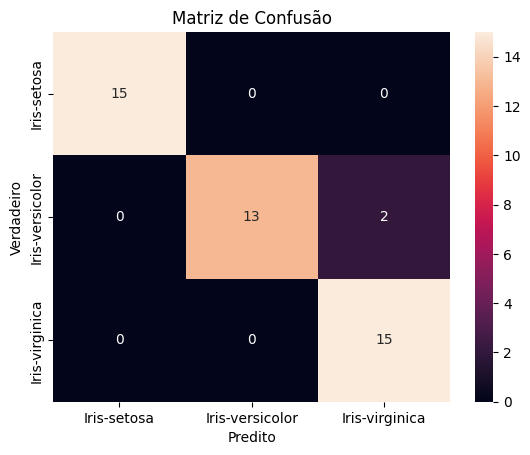

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

**One vs Rest**

In [30]:
model = OneVsRestLogisticRegression(lr=0.01, max_iters=5000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7555555555555555

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       0.88      1.00      0.94        15
Iris-versicolor       0.83      0.33      0.48        15
 Iris-virginica       0.64      0.93      0.76        15

       accuracy                           0.76        45
      macro avg       0.78      0.76      0.72        45
   weighted avg       0.78      0.76      0.72        45

Confusion Matrix:
 [[15  0  0]
 [ 2  5  8]
 [ 0  1 14]]


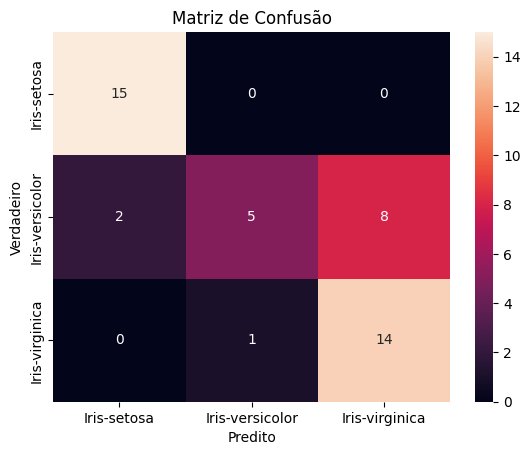

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

## Dataset_187_wine

In [32]:
%matplotlib inline
import pandas as pd
import numpy as onp
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Classes codificadas: [np.int64(1), np.int64(2), np.int64(3)]
Degree=1 → Accuracy = 0.963
Degree=2 → Accuracy = 1.000
Degree=3 → Accuracy = 1.000

Melhor grau: 2 ⇒ Accuracy = 1.000


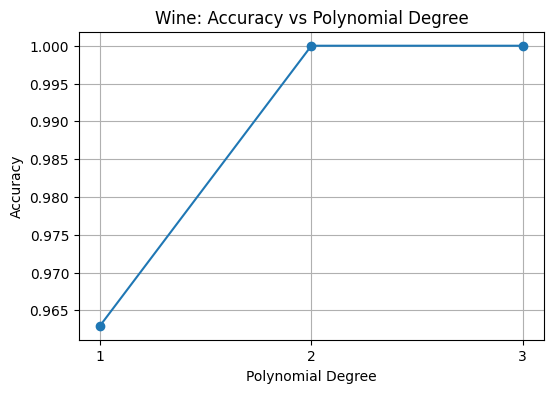

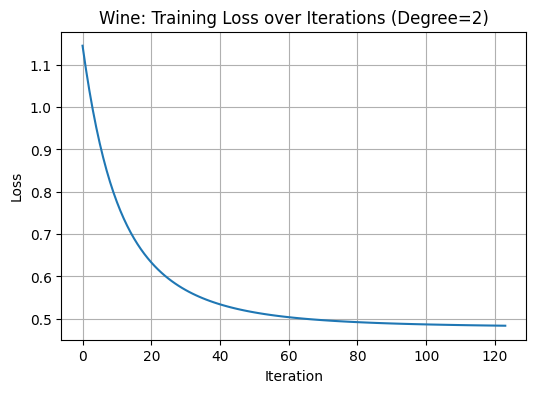

In [33]:
df_wine = pd.read_csv("multiclass_classification/dataset_187_wine.csv")
X = df_wine.iloc[:, :-1].values
y = LabelEncoder().fit_transform(df_wine.iloc[:, -1].values)
print("Classes codificadas:", list(LabelEncoder().fit(df_wine.iloc[:, -1]).classes_))

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

degrees = [1, 2, 3]
accuracies = []
models = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xt_tr = poly.fit_transform(X_tr_s)
    Xt_te = poly.transform(X_te_s)
    model = MultinomialLogisticRegression(lr=0.01, penalty="l2", C=1.0, max_iters=5000)
    model.fit(Xt_tr, y_tr)
    y_pred = model.predict(Xt_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"Degree={degree} → Accuracy = {acc:.3f}")
    accuracies.append(acc)
    models.append(model)

best_idx = onp.argmax(accuracies)
best_degree = degrees[best_idx]
best_model = models[best_idx]
print(f"\nMelhor grau: {best_degree} ⇒ Accuracy = {accuracies[best_idx]:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(degrees, accuracies, marker='o')
plt.title("Wine: Accuracy vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.xticks(degrees)
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(best_model.errors)
plt.title(f"Wine: Training Loss over Iterations (Degree={best_degree})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Degree=1 → Accuracy = 0.981
Degree=2 → Accuracy = 0.981
Degree=3 → Accuracy = 0.981

Melhor grau: 1 ⇒ Accuracy = 0.981


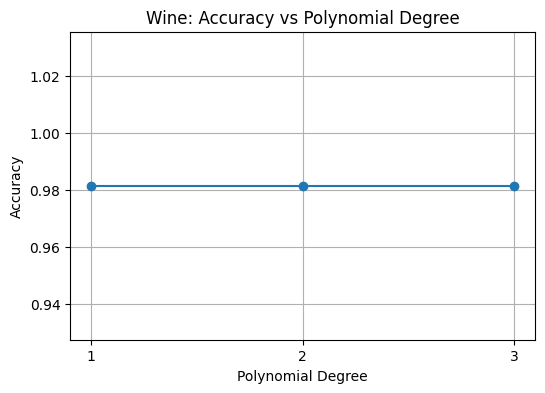

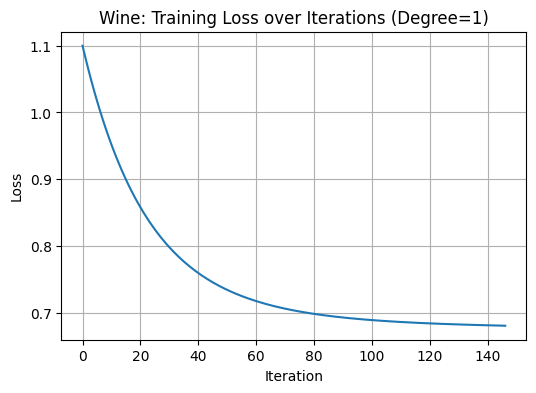

In [34]:
accuracies.clear() 

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xt_tr = poly.fit_transform(X_tr_s)
    Xt_te = poly.transform(X_te_s)
    model = OneVsRestLogisticRegression(lr=0.01, penalty="l2", C=1.0, max_iters=5000)
    model.fit(Xt_tr, y_tr)
    y_pred = model.predict(Xt_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"Degree={degree} → Accuracy = {acc:.3f}")
    accuracies.append(acc)
    models.append(model)

best_idx = onp.argmax(accuracies)
best_degree = degrees[best_idx]
best_model = models[best_idx]
print(f"\nMelhor grau: {best_degree} ⇒ Accuracy = {accuracies[best_idx]:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(degrees, accuracies, marker='o')
plt.title("Wine: Accuracy vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.xticks(degrees)
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(best_model.errors)
plt.title(f"Wine: Training Loss over Iterations (Degree={best_degree})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Dataset_54_vehicle

In [35]:
%matplotlib inline
import pandas as pd
import numpy as onp
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Degree=1 → Accuracy = 0.571
Degree=2 → Accuracy = 0.657
Degree=3 → Accuracy = 0.783


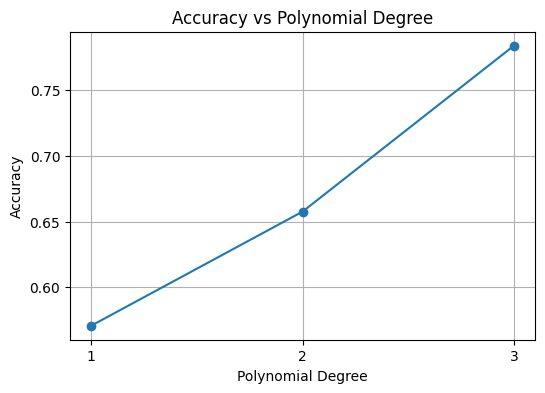

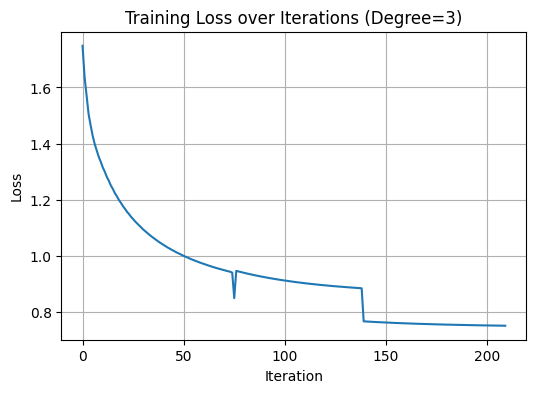


Melhor grau: 3 ⇒ Accuracy = 0.783


In [36]:
df = pd.read_csv("multiclass_classification/dataset_54_vehicle.csv")
X = df.iloc[:, :-1].values
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

degrees = [1, 2, 3]
accuracies = []
models = []
polys = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xt_tr = poly.fit_transform(X_tr_s)
    Xt_te = poly.transform(X_te_s)
    model = MultinomialLogisticRegression(lr=0.01, penalty="l2", C=1.0, max_iters=5000)
    model.fit(Xt_tr, y_tr)
    y_pred = model.predict(Xt_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"Degree={degree} → Accuracy = {acc:.3f}")
    accuracies.append(acc)
    models.append(model)
    polys.append(poly)

best_idx = onp.argmax(accuracies)
best_degree = degrees[best_idx]
best_model = models[best_idx]

plt.figure(figsize=(6,4))
plt.plot(degrees, accuracies, marker='o')
plt.title("Accuracy vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.xticks(degrees)
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(best_model.errors)
plt.title(f"Training Loss over Iterations (Degree={best_degree})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print(f"\nMelhor grau: {best_degree} ⇒ Accuracy = {accuracies[best_idx]:.3f}")


Degree=1 → Accuracy = 0.657


C:\Users\bombd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Degree=2 → Accuracy = 0.673


C:\Users\bombd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Degree=3 → Accuracy = 0.787


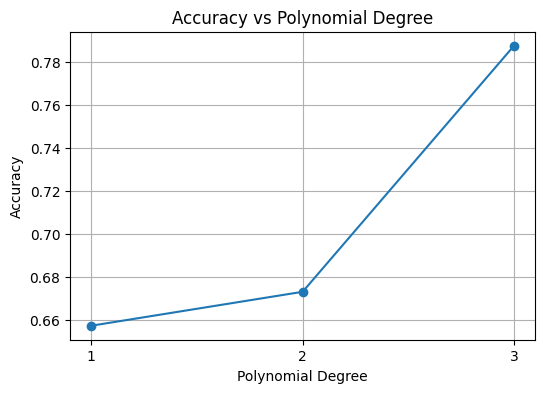

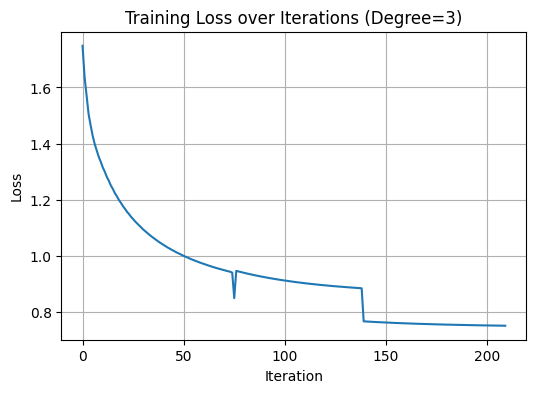


Melhor grau: 3 ⇒ Accuracy = 0.787


In [37]:
accuracies.clear() 


for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xt_tr = poly.fit_transform(X_tr_s)
    Xt_te = poly.transform(X_te_s)
    model = OneVsRestLogisticRegression(lr=0.01, penalty="l2", C=1.0, max_iters=5000)
    model.fit(Xt_tr, y_tr)
    y_pred = model.predict(Xt_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"Degree={degree} → Accuracy = {acc:.3f}")
    accuracies.append(acc)
    models.append(model)
    polys.append(poly)

best_idx = onp.argmax(accuracies)
best_degree = degrees[best_idx]
best_model = models[best_idx]

plt.figure(figsize=(6,4))
plt.plot(degrees, accuracies, marker='o')
plt.title("Accuracy vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.xticks(degrees)
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(best_model.errors)
plt.title(f"Training Loss over Iterations (Degree={best_degree})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print(f"\nMelhor grau: {best_degree} ⇒ Accuracy = {accuracies[best_idx]:.3f}")

## Dataset noise/outliers (dataset_336_SPECT)

Classes originais: [np.int64(0), np.int64(1)]
Classes codificadas: [0 1]
Accuracy: 0.8641975308641975
Confusion Matrix:
 [[ 9  8]
 [ 3 61]]


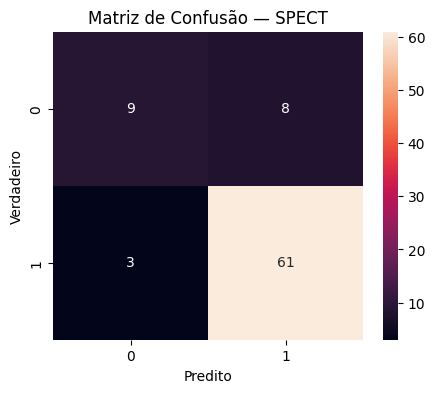

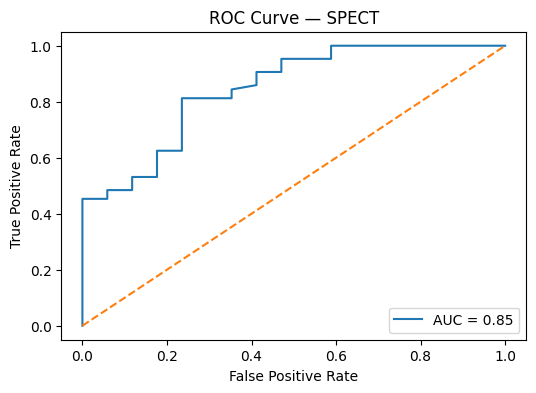

In [38]:
import pandas as pd
import numpy as onp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df_spect = pd.read_csv("noise_outliers/dataset_336_SPECT.csv")
X = df_spect.iloc[:, :-1].values
y = LabelEncoder().fit_transform(df_spect.iloc[:, -1].values)
print("Classes originais:", list(LabelEncoder().fit(df_spect.iloc[:, -1]).classes_))
print("Classes codificadas:", onp.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = BinaryLogisticRegression(lr=0.01, max_iters=2000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
probs  = model.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=LabelEncoder().fit(df_spect.iloc[:, -1]).classes_,
            yticklabels=LabelEncoder().fit(df_spect.iloc[:, -1]).classes_)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão — SPECT")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SPECT")
plt.legend(loc="lower right")
plt.show()


## Dataset_375_JapaneseVowels

Multinomial Logistic Regression (grau 1) → Accuracy: 0.699
Multinomial Logistic Regression (grau 2) → Accuracy: 0.820
Multinomial Logistic Regression (grau 3) → Accuracy: 0.933

Melhor modelo (Multinomial Logistic Regression): grau = 3, Accuracy = 0.933
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       329
           1       0.89      0.93      0.91       297
           2       0.90      0.98      0.94       484
           3       0.93      0.98      0.96       442
           4       0.91      0.96      0.93       235
           5       0.99      1.00      0.99       289
           6       0.97      0.98      0.97       351
           7       0.96      0.69      0.80       304
           8       0.90      0.85      0.88       258

    accuracy                           0.93      2989
   macro avg       0.93      0.93      0.93      2989
weighted avg       0.93      0.93      0.93      2989



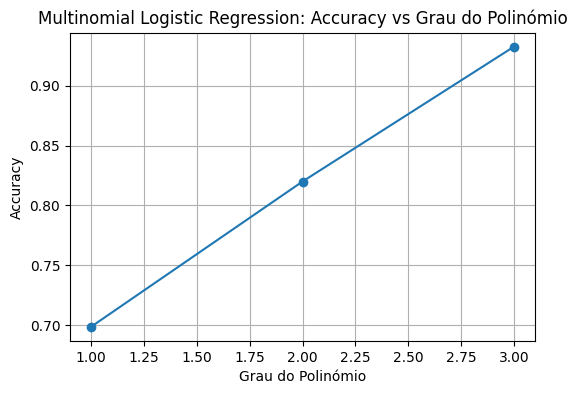

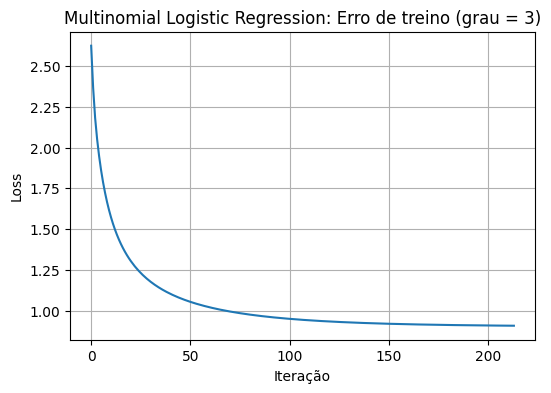

One-vs-Rest Logistic Regression (grau 1) → Accuracy: 0.816


C:\Users\bombd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


One-vs-Rest Logistic Regression (grau 2) → Accuracy: 0.447


C:\Users\bombd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


One-vs-Rest Logistic Regression (grau 3) → Accuracy: 0.970

Melhor modelo (One-vs-Rest Logistic Regression): grau = 3, Accuracy = 0.970
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       329
           1       0.98      0.97      0.98       297
           2       0.97      0.98      0.98       484
           3       0.98      0.99      0.99       442
           4       0.95      0.95      0.95       235
           5       1.00      0.99      0.99       289
           6       0.99      0.98      0.99       351
           7       0.94      0.90      0.92       304
           8       0.91      0.97      0.94       258

    accuracy                           0.97      2989
   macro avg       0.97      0.97      0.97      2989
weighted avg       0.97      0.97      0.97      2989



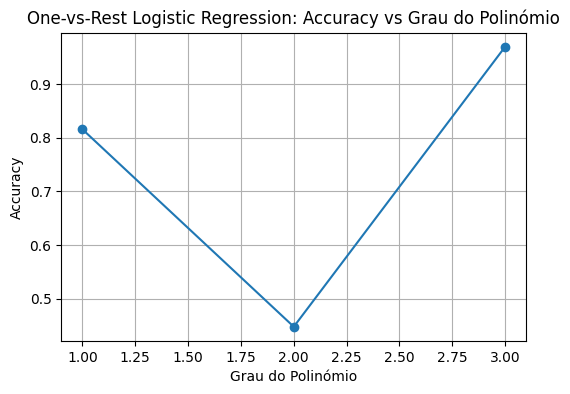

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

csv_path = "multiclass_classification/dataset_375_JapaneseVowels.csv"
target_column = -1
degrees = [1, 2, 3]

df = pd.read_csv(csv_path)
X = df.iloc[:, :-1]
y = df.iloc[:, target_column]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

def avaliar_modelo(model_class, model_name):
    accuracies = []
    models = []
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        Xt_train = poly.fit_transform(X_train)
        Xt_test = poly.transform(X_test)

        model = model_class(lr=0.01, penalty="l2", C=1.0, max_iters=5000)
        model.fit(Xt_train, y_train)
        y_pred = model.predict(Xt_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} (grau {degree}) → Accuracy: {acc:.3f}")
        accuracies.append(acc)
        models.append(model)

    best_idx = np.argmax(accuracies)
    best_model = models[best_idx]
    best_degree = degrees[best_idx]

    print(f"\nMelhor modelo ({model_name}): grau = {best_degree}, Accuracy = {accuracies[best_idx]:.3f}")
    target_names = [str(cls) for cls in np.unique(y_test)]
    print(classification_report(y_test, best_model.predict(poly.transform(X_test)), target_names=target_names))

    plt.figure(figsize=(6, 4))
    plt.plot(degrees, accuracies, marker='o')
    plt.title(f"{model_name}: Accuracy vs Grau do Polinómio")
    plt.xlabel("Grau do Polinómio")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    if hasattr(best_model, "errors"):
        plt.figure(figsize=(6, 4))
        plt.plot(best_model.errors)
        plt.title(f"{model_name}: Erro de treino (grau = {best_degree})")
        plt.xlabel("Iteração")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

avaliar_modelo(MultinomialLogisticRegression, "Multinomial Logistic Regression")
avaliar_modelo(OneVsRestLogisticRegression, "One-vs-Rest Logistic Regression")


## Conclusão Final

### Objetivo
Este trabalho teve como objetivo adaptar a regressão logística, originalmente limitada a problemas binários, para tarefas de classificação multiclasse. Após observar os limites da implementação inicial, foram exploradas duas abordagens clássicas para resolver este tipo de problema: **Multinomial Logistic Regression** e **One-vs-Rest Logistic Regression**.

---

### Comparação com a Implementação Original

A primeira versão da regressão logística, implementada na Fase 1, mostrou-se eficaz apenas para classificações binárias. Ao ser aplicada diretamente em datasets com múltiplas classes, os resultados foram fracos e inconsistentes. A ausência de um mecanismo para lidar com múltiplas classes impossibilitou uma aprendizagem adequada, resultando em acurácias significativamente inferiores às abordagens seguintes.

---

### Abordagem 1: Multinomial Logistic Regression (Softmax)

A regressão logística multinomial estende o modelo binário ao utilizar a função **softmax**, permitindo calcular as probabilidades para todas as classes simultaneamente.

#### Características:
- Treina **um único modelo multiclasse**.
- A função de custo é ajustada com **entropia cruzada categórica**.
- Mais sensível a problemas de escala e complexidade do input.
- Apresentou bom desempenho em datasets limpos e balanceados.
- Em casos com muitos atributos e `PolynomialFeatures` de grau elevado, sofreu com instabilidades numéricas.

---

### Abordagem 2: One-vs-Rest Logistic Regression (OvR)

Esta abordagem divide o problema multiclasse em vários problemas binários. Para cada classe, é treinado um classificador binário que a distingue das restantes.

#### Características:
- Treina **um modelo binário por classe**.
- Mais flexível e robusto a variações nos dados.
- Mais estável quando aplicadas transformações polinomiais.
- Desempenho competitivo com a abordagem multinomial.
- Facilita a interpretação e ajuste individual de modelos por classe.

---

### Diferenças e Semelhanças

| Critério                   | Multinomial Logistic Regression | One-vs-Rest Logistic Regression |
|----------------------------|----------------------------------|----------------------------------|
| Tipo de modelo             | Único modelo multiclasse        | Múltiplos modelos binários       |
| Treinamento                | Mais rápido com poucas classes  | Escala melhor com muitas classes |
| Probabilidades             | Normalizadas via softmax        | Independentes por classe         |
| Complexidade computacional| Mais intensiva no softmax       | Mais simples e modular           |
| Estabilidade               | Pode divergir com polinómios altos | Mais estável mesmo com `degree=3` |
| Interpretação              | Global, multiclasse             | Por classe, binária              |

---

### Conclusão Geral

Ambas as abordagens superaram claramente a versão binária original, revelando-se estratégias eficazes para classificação multiclasse.

- A **Multinomial Logistic Regression** mostrou-se mais eficiente e direta em datasets equilibrados e com número moderado de classes.
- A **One-vs-Rest Logistic Regression** destacou-se pela sua robustez e adaptabilidade, especialmente útil em datasets com mais classes ou maior variabilidade.

A escolha entre uma ou outra depende fortemente do contexto: número de classes, dimensionalidade, ruído nos dados e necessidade de interpretabilidade individual.


**Bibliografia**

Machine Learning Mastery. One-vs-Rest and One-vs-One for Multi-Class Classification: https://www.machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

GeeksforGeeks. One-vs-Rest Strategy for Multi-Class Classification: https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/

Wikipedia. Função Softmax: https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_softmax

GeeksforGeeks. Softmax Activation Function in Neural Networks: https://www.geeksforgeeks.org/the-role-of-softmax-in-neural-networks-detailed-explanation-and-applications/